# Custom dashboards
In this notebook we will take a look at how to customize dashboard and how to create custom dashboards.

At first we will build a simple gallery that displays the image of a record with some additional data. Than we will go a bit more into detail how a dashboard is constructed and what is required and build a dashboard that uses the gallery from before as part of it.

## Custom gallery
We will create a simple gallery that takes a list of records and displayes the image in the record and some additional data.

In [54]:
import json

import icedata
from icevision.data.data_splitter import RandomSplitter
from icevision.visualize.draw_data import draw_sample
import matplotlib.pyplot as plt
import panel as pn
import pandas as pd

from icevision_dashboards.core.dashboards import BaseGallery, Dashboard

In [55]:
# make sure panel output works in jupyter notebooks
pn.extension()

In [58]:
# load the Fridge dataset
path = icedata.fridge.load_data()
# get the class map
class_map = icedata.fridge.class_map()
# parse the data
parser = icedata.fridge.parser(data_dir=path)
# we just want to have a look at the data, so we don't split the data
records = parser.parse(RandomSplitter([1]))[0]

  0%|          | 0/128 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/128 [00:00<?, ?it/s]

In [59]:
# function that creates a plot for a record
def gallery_plot(record, width=1000, height=700):
    # create a plot of the image
    image_array = draw_sample(record.load())
    fig, ax = plt.subplots(1,1)
    ax.imshow(image_array)
    ax.grid(False)
    plt.close()
    image_widget = pn.pane.Matplotlib(fig, width=600)
    # display the additional data of the image in json format
    data_dict = record.as_dict()
    # make sure all information in the data_dict is json serializable
    data_dict["common"]["filepath"] = str(data_dict["common"]["filepath"])
    data_dict["detection"]["bboxes"] = [bbox.xyxy for bbox in data_dict["detection"]["bboxes"]]
    # convert the labels to the names
    data_dict["detection"]["labels"] = [class_map.get_by_id(label) for label in data_dict["detection"]["labels"]]
    json_widget = pn.pane.JSON(json.dumps(data_dict))
    # compose the two parts
    gui = pn.Row(image_widget, json_widget, width=width, height=height)
    return gui

Row(height=700, sizing_mode='fixed', width=1000)
    [0] Matplotlib(Figure, width=600)
    [1] JSON(str)
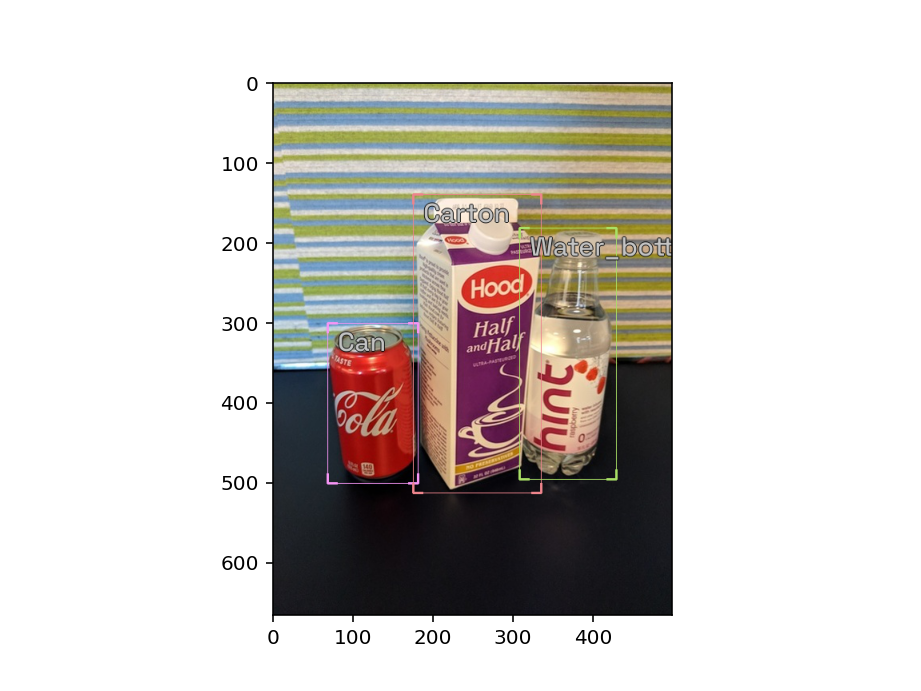

In [60]:
gallery_plot(records[1])

Now that we have a function to display a record with some additional data about the record we can now create a gallery based on that. The gallery will take a list of records as input and than show the visualization above for each entry. The `__init__` of the BaseGallery class (from which we will inherit) looks like this:

```python
def __init__(self, data, width=500, height=500):
    """Data can be anyting, the handling of the data is done via the functions `get_image_by_image_id` and `get_num_entries`"""
    self.data = data
    self.num_entries = self.get_num_entries()
    self.UPDATING = False
    super().__init__(width, height)
```

The important part here is that the data we give to the `__init__` function will be the data for the gallery. All we need to do, is to define two functions for the gallery: `get_num_entries` which returns the number of entries in the data and `get_image_by_index` which receives the current index and has to return a panel object that can be displayed (here we use the function defined above).

In [61]:
class ListGallery(BaseGallery):
    def get_num_entries(self):
        # the number of entries is just the lenght of the list of records 
        return len(self.data)
    
    def get_image_by_index(self, index):
        # for visualization we take the record at the current index and return the visualization defined above
        return gallery_plot(self.data[index])

Column
    [0] Row(align='center', height=50)
        [0] Button(name='<', width=166)
        [1] TextInput(value='1', width=83)
        [2] Row(width=83)
            [0] Markdown(str)
        [3] Button(name='>', width=166)
    [1] Row(align='center')
        [0] Row(height=700, sizing_mode='fixed', width=1000)
            [0] Matplotlib(Figure, width=600)
            [1] JSON(str)
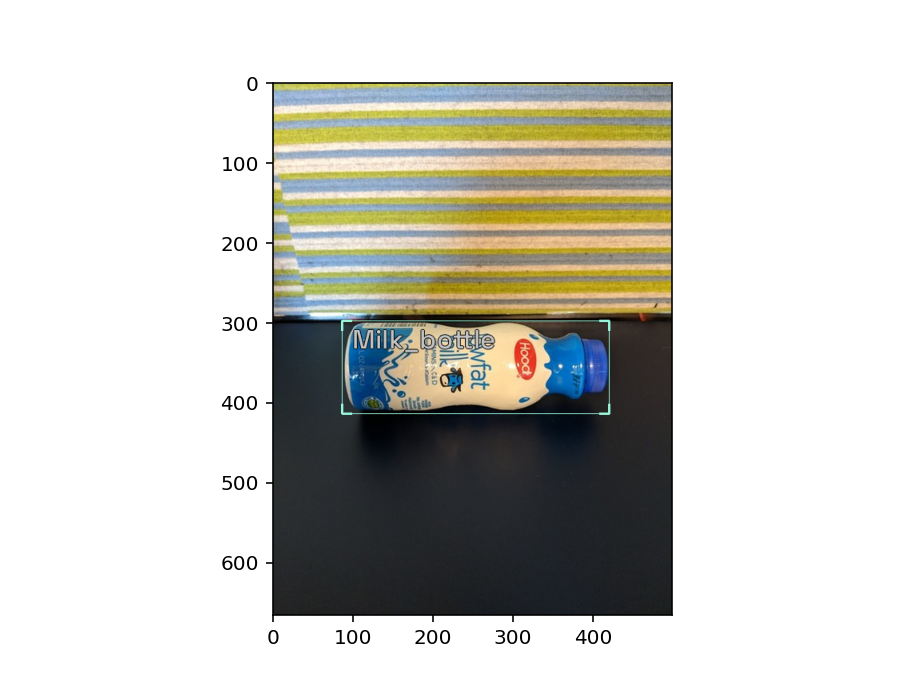

In [62]:
# we instanciate the gallery with the records from the fridge dataset
list_gallery = ListGallery(records)
# to display the gallery we call the .show function
list_gallery.show()

Because the BaseGallery class is base on the Dashboard class it also has the two functions `build_gui` and `show` both are already defined as the structure of the gallery is predefined and only the representation of the data is required. We will talk more on the structure of a dashboard in the next section.

## Custom dashboard

The base class for all dashboards is defined as:

```python
class Dashboard(ABC):
    """
    Abstract base class for dashboards. Requires the functions `build_gui` and `show` to be defined.
    build_gui should define the gui elements/plots for the dashboard and show should return a panel object that can be displayed.
    In most cases build_gui will call some other functions that return gui components and combine them into one element and than register the combined element as an attribute of the class (e.g. self.gui).
    In most cases the show function than returns the gui element defined in build_gui (e.g. self.gui).
    """
    def __init__(self, width: int = 500, height: int = 500):
        """Takes width and hight as arguments and calls the `build_gui` function at the end."""
        self.width = width
        self.height = height
        self.build_gui()
        
    @abstractmethod
    def show(self):
        pass
    
    @abstractmethod
    def build_gui(self):
        pass
```

All classes that inherit from the Dashboard class are required to implement at least two functions: `show` and `build_gui`, but in most cases the `__init__` will also be overwritten. When the `__init__` function is overwritten the `super.__init__` should be called at the end because it will call the `build_gui` function.

The `build_gui` function sould build the gui for the dashboard, for all dashboards defined in IcevisionDashboards the function will build the gui and set it to `self.gui = ...`. This allows for Dashboards to be created from other dashboards by combining them.

The `show` function returns the gui of the dashboard (normaly a panel object). But for more complex dashboards you can use the `show` function to alter the display functionality of a dashboard.

### Building the custom dashboard
Next we will build a dashboard that will display some stats about the list of records at the top and show a the gallery we created above below the stats.

In [63]:
class CustomDashboard(Dashboard):
    def __init__(self, records, width=600, height=500):
        self.records = records
        # calculate stats to display above the images
        self.record_stats = self.calculate_stats()
        super().__init__(width, height)
        
    def calculate_stats(self):
        # calculate some basic stats and put the into a pandas df
        data = {}
        data["num_records"] = len(self.records)
        # -1 to remove the background label
        data["num_classes"] = len(self.records[0].detection.class_map)-1
        data["classes"] = self.records[0].detection.class_map._id2class[1:]
        df = pd.DataFrame([data])
        return df
        
    def build_gui(self):
        # use the gallery we defined above
        self.gallery = ListGallery(self.records)
        # create a table widget from the dataframe
        self.stats_table = pn.widgets.DataFrame(self.record_stats, height=100)
        # compose the two parts
        self.gui = pn.Column(
            # use rows to center the parts horizontaly
            pn.Row(self.stats_table, align="center"),
            pn.Row(self.gallery.gui, align="center"),
        )
    
    def show(self):
        return self. gui

Column
    [0] Row(align='center')
        [0] DataFrame(height=100, value=   num_records  num_classe...)
    [1] Row(align='center')
        [0] Column
            [0] Row(align='center', height=50)
                [0] Button(name='<', width=166)
                [1] TextInput(value='1', width=83)
                [2] Row(width=83)
                    [0] Markdown(str)
                [3] Button(name='>', width=166)
            [1] Row(align='center')
                [0] Row(height=700, sizing_mode='fixed', width=1000)
                    [0] Matplotlib(Figure, width=600)
                    [1] JSON(str)
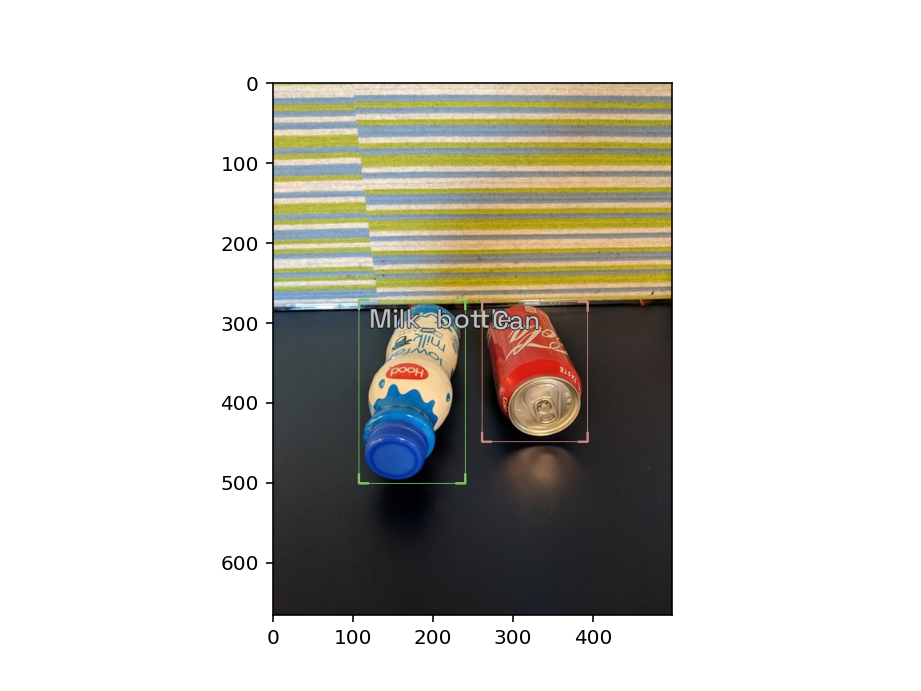

In [53]:
custom_dashboard = CustomDashboard(records)
custom_dashboard.show()